## **A quick flight to the edge of Data Science: Tidy Modelling with R**




### Meet the data

In this sections, we'll build a multiclass classifier for classifying penguins!

The `palmerpenguins` data contains size measurements for three penguin species observed on three islands in the Palmer Archipelago, Antarctica.


### A quick look at the data


In [43]:
# Load the required packages and make them available in your current R session
suppressPackageStartupMessages({
  library(tidyverse)
  library(tidymodels)
})

# Import data
penguins <- read_csv("penguins.csv", show_col_types = FALSE) %>% 
  mutate(species = factor(species))

# View the first 10 observations
penguins %>%
  slice_head(n = 10)

dim(penguins)

bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
39.1,18.7,181,3750,Adelie
39.5,17.4,186,3800,Adelie
40.3,18.0,195,3250,Adelie
36.7,19.3,193,3450,Adelie
39.3,20.6,190,3650,Adelie
38.9,17.8,181,3625,Adelie
39.2,19.6,195,4675,Adelie
34.1,18.1,193,3475,Adelie
42.0,20.2,190,4250,Adelie


[1] 342   5

The data contains the following columns:


The **species** column containing penguin species `Adelie`, `Chinstrap`, or `Gentoo`, is the label we want to train a model to predict.




In [44]:
# Check missing values
anyNA(penguins)


[1] FALSE

No missing values. Good start!

For brevity, let's make one exploratory plot.



bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
39.1,18.7,181,3750,Adelie
39.5,17.4,186,3800,Adelie
40.3,18.0,195,3250,Adelie
36.7,19.3,193,3450,Adelie
39.3,20.6,190,3650,Adelie
38.9,17.8,181,3625,Adelie
39.2,19.6,195,4675,Adelie
34.1,18.1,193,3475,Adelie
42.0,20.2,190,4250,Adelie


species,predictors,values
<fct>,<chr>,<dbl>
Adelie,body_mass_g,3550.0
Adelie,bill_length_mm,40.2
Chinstrap,bill_depth_mm,16.6
Gentoo,bill_depth_mm,14.5
Adelie,bill_depth_mm,17.9
Adelie,bill_depth_mm,17.5
Adelie,bill_length_mm,37.3
Adelie,bill_length_mm,41.3
Adelie,body_mass_g,4600.0


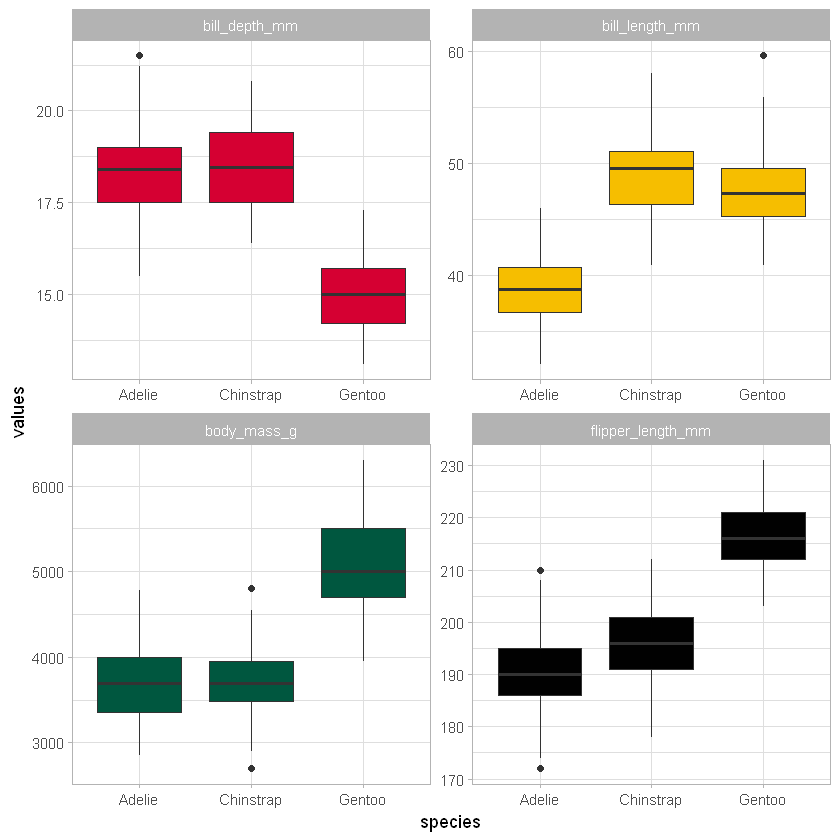

In [45]:
# View the first 10 observations
penguins %>%
  slice_head(n = 10)

# Pivot data to a long format
penguins_select_long <- penguins %>% 
  pivot_longer(!species, names_to = "predictors", values_to = "values")

penguins_select_long %>% 
  slice_sample(n = 10)

# Make box plots
theme_set(theme_light())
penguins_select_long %>%
  ggplot(mapping = aes(x = species, y = values, fill = predictors)) +
  geom_boxplot() +
  facet_wrap(~predictors, scales = "free") +
  paletteer::scale_fill_paletteer_d("nbapalettes::supersonics_holiday") +
  theme(legend.position = "none")
  


From the box plots, it looks like species `Adelie` and `Chinstrap` have similar data profiles for bill_depth, flipper_length, and body_mass, but Chinstraps tend to have longer bill_length. `Gentoo` tends to have fairly clearly differentiated features from the others; which should help us train a good classification model.

## Build a model

### 1. Data budgeting

To get started, let’s split this single dataset into two: a training set and a testing set. We’ll keep most of the rows in the original dataset (subset chosen randomly) in the training set. The training data will be used to fit the model, and the testing set will be used to measure model performance.


In [26]:
# For reproducibility
set.seed(2056)

# Split data 70%-30% into training set and test set
penguins_split <- penguins %>% 
  initial_split(prop = 0.70)

# Extract data in each split
penguins_train <- training(penguins_split)
penguins_test <- testing(penguins_split)

# Print the number of observations in each split
cat("Training cases: ", nrow(penguins_train), "\n",
    "Test cases: ", nrow(penguins_test), sep = "")


Training cases: 239
Test cases: 103

### 2. Make a model specifcation

<p >
<center><img src = "images/parsnip.png", width= 500>




Tidymodels provides a unified interface to models that can be used to try a range of models by specifying three concepts:

- Model **type** differentiates models such as logistic regression, decision tree models, and so forth.

- Model **engine** is the computational tool which will be used to fit the model. Often these are R packages, such as "lm" or "ranger"

- Model **mode** includes common options like regression and classification; some model types support either of these while some only have one mode.

In [46]:
# Specify a random forest model via ranger
rf_spec <- rand_forest() %>% 
  set_engine("ranger") %>% 
  set_mode("classification")

print(rf_spec)

Random Forest Model Specification (classification)

Computational engine: ranger 



### 3. Train and evaluate a model

Now that your `penguins_train` data is ready, you can fit a set of models with tidymodels.

In [47]:
# Train a regression model
set.seed(2056)
penguins_mod <- rf_spec %>% 
  fit(species ~ ., data = penguins_train)

# Print the model
print(penguins_mod)

parsnip model object

Fit time:  30ms 
Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, num.threads = 1,      verbose = FALSE, seed = sample.int(10^5, 1), probability = TRUE) 

Type:                             Probability estimation 
Number of trees:                  500 
Sample size:                      239 
Number of independent variables:  4 
Mtry:                             2 
Target node size:                 10 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.02795154 


Now we can use the trained model to predict the labels for the test features, and evaluate performance. When making predictions, the tidymodels convention is to always produce a tibble of results with standardized column names.



In [48]:
# Make predictions for the test set
penguins_pred <- penguins_mod %>% 
  predict(new_data = penguins_test)

penguins_pred %>% 
  slice_head(n = 10)

.pred_class
<fct>
Adelie
Adelie
Adelie
Adelie
Adelie
Adelie
Adelie
Adelie
Adelie


This makes it easy to combine the original data and the predictions in a usable format:

In [49]:
# Combine predictions with test set
penguins_results <- penguins_test %>% 
  bind_cols(penguins_pred)

# Print predictions
penguins_results %>% 
  slice_sample(n = 10)



bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species,.pred_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
42.5,16.7,187,3350,Chinstrap,Chinstrap
49.6,16.0,225,5700,Gentoo,Gentoo
38.5,17.9,190,3325,Adelie,Adelie
46.7,15.3,219,5200,Gentoo,Gentoo
55.8,19.8,207,4000,Chinstrap,Chinstrap
46.4,17.8,191,3700,Chinstrap,Chinstrap
35.5,17.5,190,3700,Adelie,Adelie
47.5,14.2,209,4600,Gentoo,Gentoo
40.5,18.9,180,3950,Adelie,Adelie


Now, let's look at the confusion matrix for our model



In [50]:
# Confusion matrix
penguins_results %>% 
  conf_mat(truth = species, estimate = .pred_class) %>% 
  print()


           Truth
Prediction  Adelie Chinstrap Gentoo
  Adelie        47         1      0
  Chinstrap      1        19      0
  Gentoo         0         0     35


The confusion matrix shows the intersection of predicted and actual label values for each class - in simple terms, the diagonal intersections from top-left to bottom-right indicate the number of correct predictions.

When dealing with multiple classes, it's generally more intuitive to visualize this as a heat map, like this:


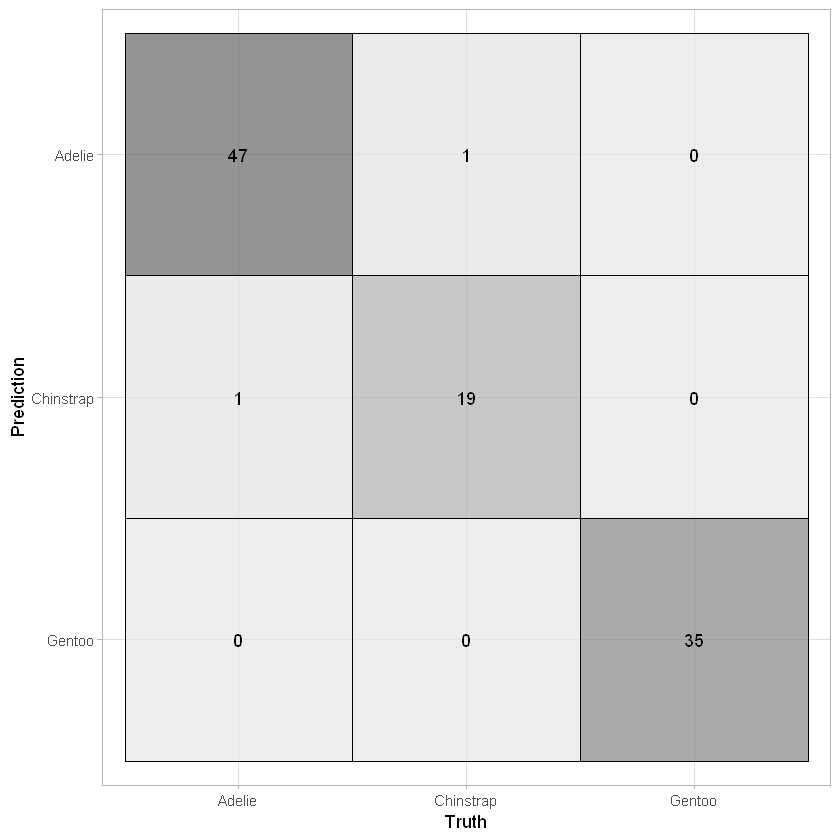

In [51]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
penguins_results %>% 
  conf_mat(species, .pred_class) %>% 
  autoplot(type = "heatmap")


The darker squares in the confusion matrix plot indicate high numbers of cases, and you can hopefully see a diagonal line of darker squares indicating cases where the predicted and actual label are the same.

Let's now calculate summary statistics for the confusion matrix.


In [52]:
# Statistical summaries for the confusion matrix
conf_mat(data = penguins_results, truth = species, estimate = .pred_class) %>% 
  summary()  %>% 
  filter(.metric %in% c("accuracy", "sens", "ppv"))


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9805825
sens,macro,0.9763889
ppv,macro,0.9763889


The tibble shows the overall metrics of how well the model performs across all three classes.



Good job! A working model 🐧🐧! 
### **Wrapping up and next steps**

<p >
<img src = "images/giphy_p.gif", class = "center", width= 300>

Congratulations on building a random forest classification model in R. Some possible next steps (covered in the upcoming learning path) would be:

- Feature Engineering
- Tuning model hyperparameters
- Comparing performance across many models
- Deploying model to [Azure Machine Learning Studio](https://ml.azure.com/)

